In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
edges = network.get_edgelist(edge_types=["d"], node_list=network.nodes["GE"], databases=["BioGRID"])
network.G.remove_edges_from(edges)

In [4]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network_val.multi_omics_data = luad_data
    network.process_genes_info()
    network_val.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -44
Total nodes (filtered): 32697
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -21066
Total nodes (filtered): 11675


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

KeyboardInterrupt: 

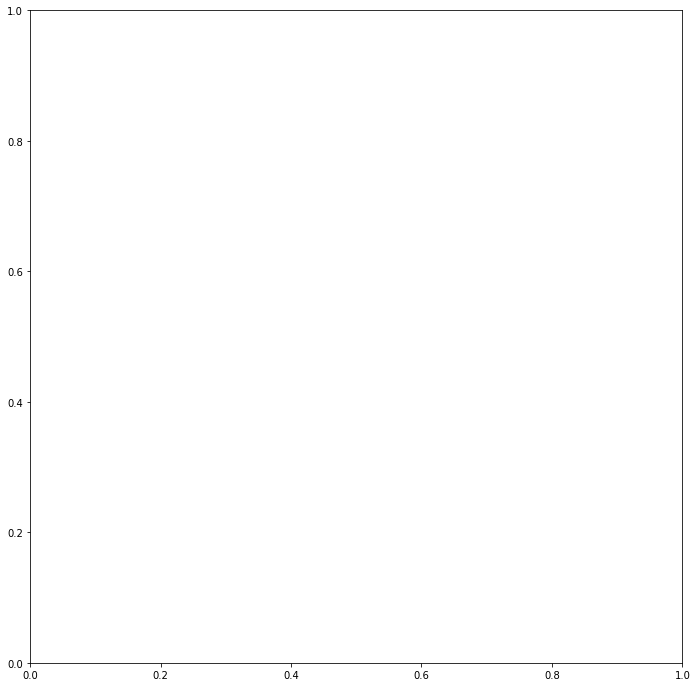

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

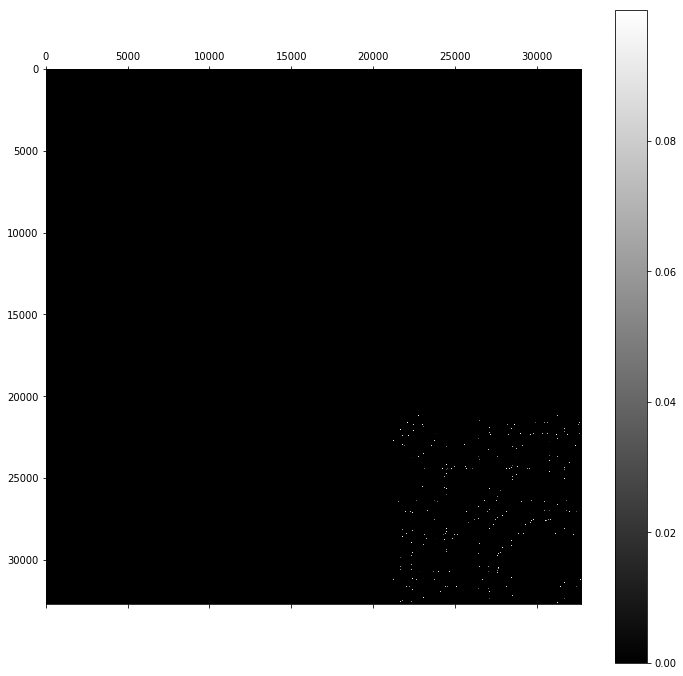

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

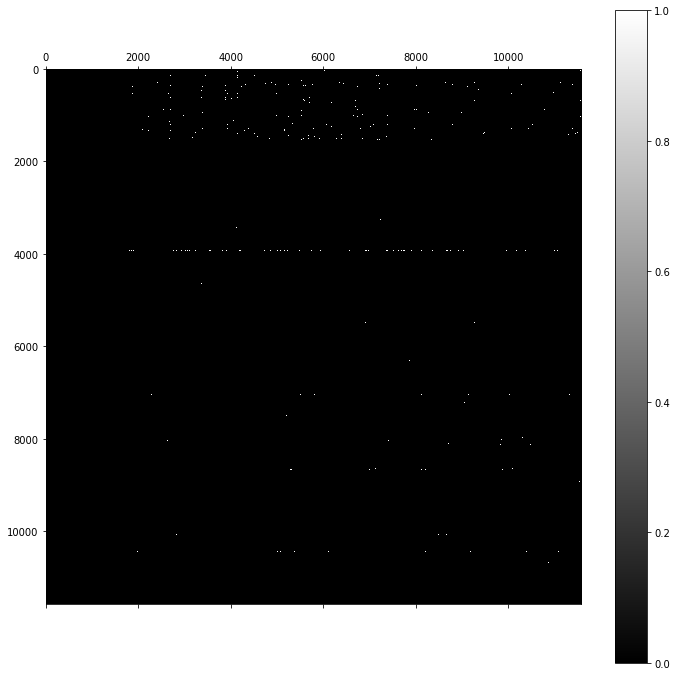

In [5]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [4]:
params = {
    'd': 512, 
    'lr': 0.0005, 
    'margin': 0.2,
    'compression_func': 'log',
    'max_length': 2500, 
    'directed_proba': 0.8, 
    'truncating': 'random', 
    
    'conv1_kernel_size': 18, 
    'max1_pool_size': 3, 
    'conv2_kernel_size': 4, 
    'max2_pool_size': 4, 
    'lstm_unit_size': 320, 
    'dense2_unit_size': None, 
    'dense1_unit_size': 1024, 
    'embedding_normalization': True
}

In [5]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

siamese = SiameseOnlineTripletGraphEmbedding(batch_size=386, verbose=True)
# siamese = SiameseGraphEmbedding(d=128, batch_size=1024, lr=0.001, epochs=50, negative_sampling_ratio=2.0,
#                                  max_length=2000, truncating="post", verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

Using TensorFlow backend.


SiameseOnlineTripletGraphEmbedding(batch_size=386, compression_func='log',
                  conv1_kernel_size=18, conv2_kernel_size=4, d=512,
                  dense1_unit_size=1024, dense2_unit_size=None,
                  directed_proba=0.8, epochs=10, lr=0.0005,
                  lstm_unit_size=320, margin=0.2, max1_pool_size=3,
                  max2_pool_size=4, max_length=2500,
                  negative_sampling_ratio=2.0, seed=0, truncating='random',
                  verbose=True)

In [8]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=False, 
    n_steps=250, validation_steps=None, 
    tensorboard=False,
    seed=0)

Epoch 1/10
250/250 [==============================] - 427s 2s/step - loss: 0.0292 - val_loss: 0.0046
Epoch 2/10
250/250 [==============================] - 413s 2s/step - loss: 0.0226 - val_loss: 0.0023
Epoch 2/10
Epoch 3/10
250/250 [==============================] - 404s 2s/step - loss: 0.0223 - val_loss: 0.0256
Epoch 4/10
Epoch 3/10
250/250 [==============================] - 402s 2s/step - loss: 0.0211 - val_loss: 5.0968e-07
Epoch 5/10
250/250 [==============================] - 404s 2s/step - loss: 0.0177 - val_loss: 0.0000e+00
Epoch 6/10
250/250 [==============================] - 407s 2s/step - loss: 0.0147 - val_loss: 0.0000e+00
Epoch 7/10
250/250 [==============================] - 400s 2s/step - loss: 0.0138 - val_loss: 2.9292e-06
Epoch 8/10
250/250 [==============================] - 396s 2s/step - loss: 0.0132 - val_loss: 0.0000e+00
Epoch 9/10
Epoch 8/10
250/250 [==============================] - 401s 2s/step - loss: 0.0125 - val_loss: 7.4615e-06
Epoch 10/10
250/250 [=============

# Visualize Embeddings

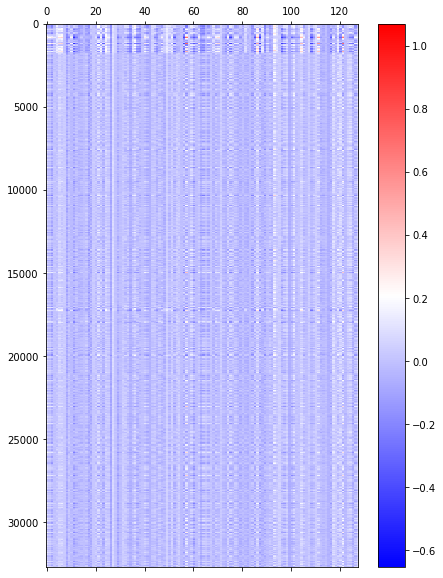

In [9]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

In [17]:
delattr(siamese, "reconstructed_adj")

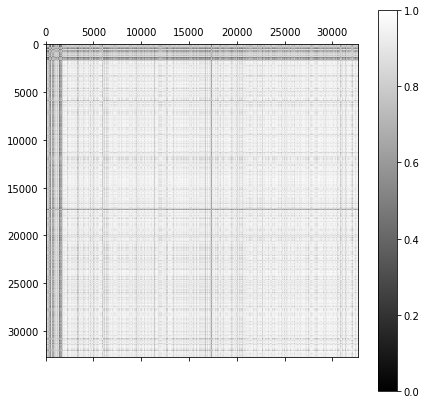

In [18]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list), figsize=(7,7))

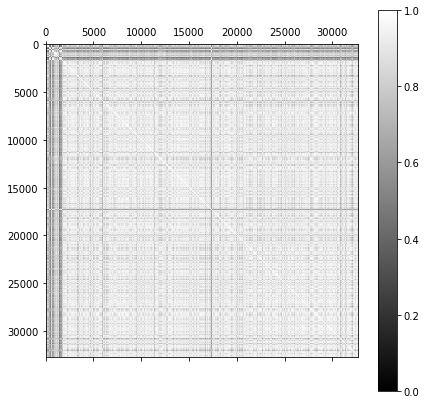

In [19]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u"), figsize=(7,7))

# Save Model & Embedding

In [10]:
siamese.lstm_network.save("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_triplet_128.randtrunc.multi_seq_UT.biogrid.full.euclidean.e50.model.h5")
# siamese.alpha_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")

In [11]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.triplet.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                        variable_length=False, recompute=False, minlen=100)

# Import different models

In [20]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
print()

node2vec imported (20447, 128)
LINE imported (20447, 128)
HOPE imported (20447, 128)
SDNE imported (20447, 128)
rna2rna imported (32663, 128)



In [21]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
methods["siamese"] = siamese

# Prepare True label

In [23]:
from moge.network.edge_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=1,
                             maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_Ed.on_epoch_end()


Ed_count: 88283 , Eu_count: 0 , En_count: 0
Ens_count: 176566
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


# Plot Precision-Recall Curve

lncrna2target
Ed_count: 564 , Eu_count: 0 , En_count: 0


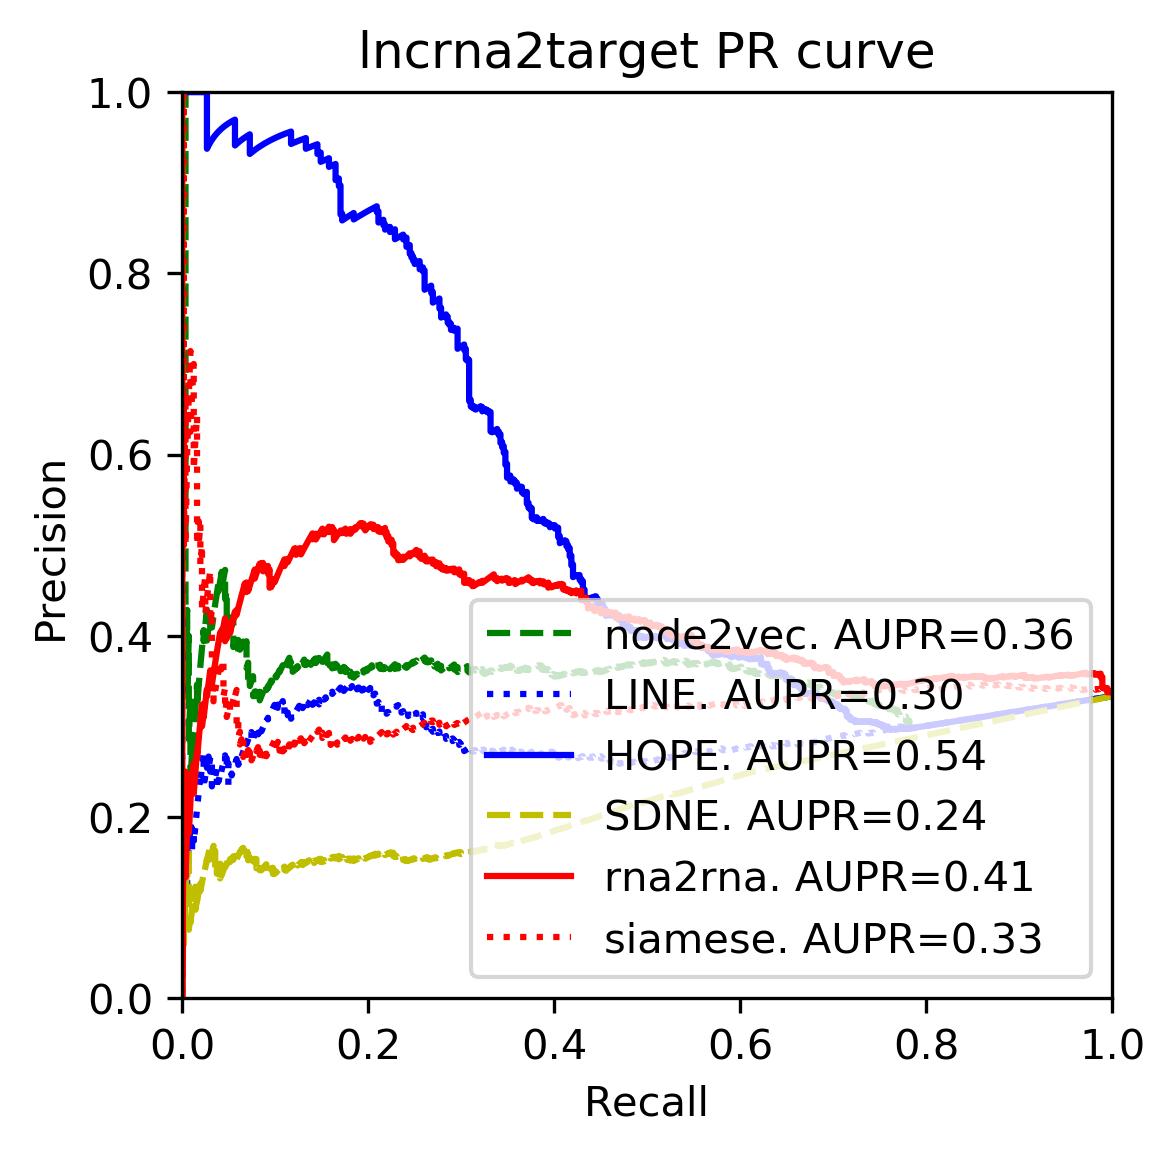

miRTarBase
Ed_count: 55895 , Eu_count: 0 , En_count: 0


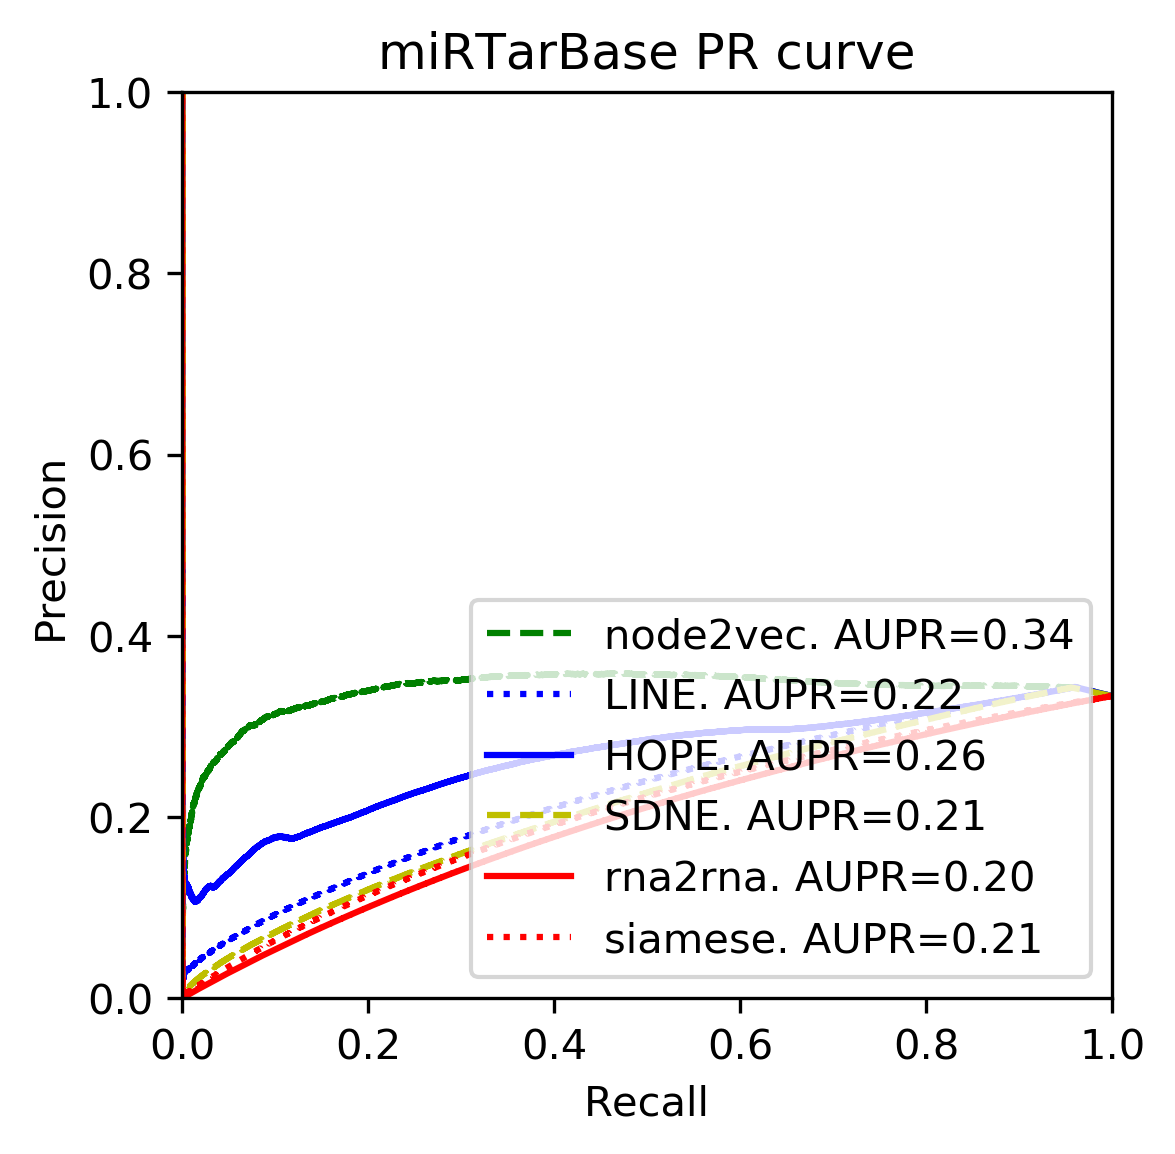

BioGRID
Ed_count: 31633 , Eu_count: 0 , En_count: 0


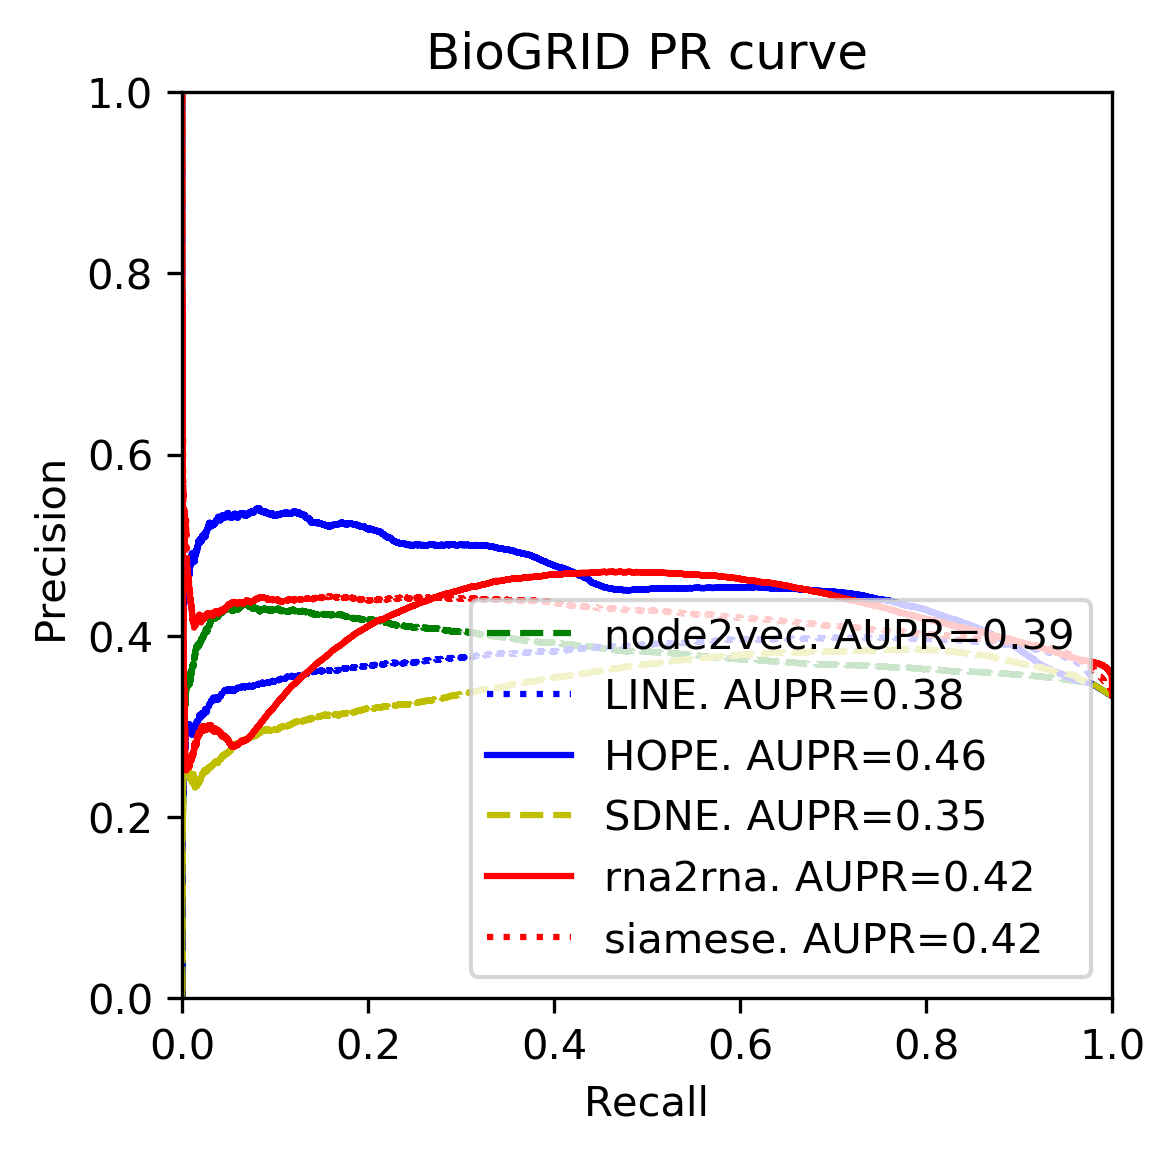

lncRInter
Ed_count: 191 , Eu_count: 0 , En_count: 0


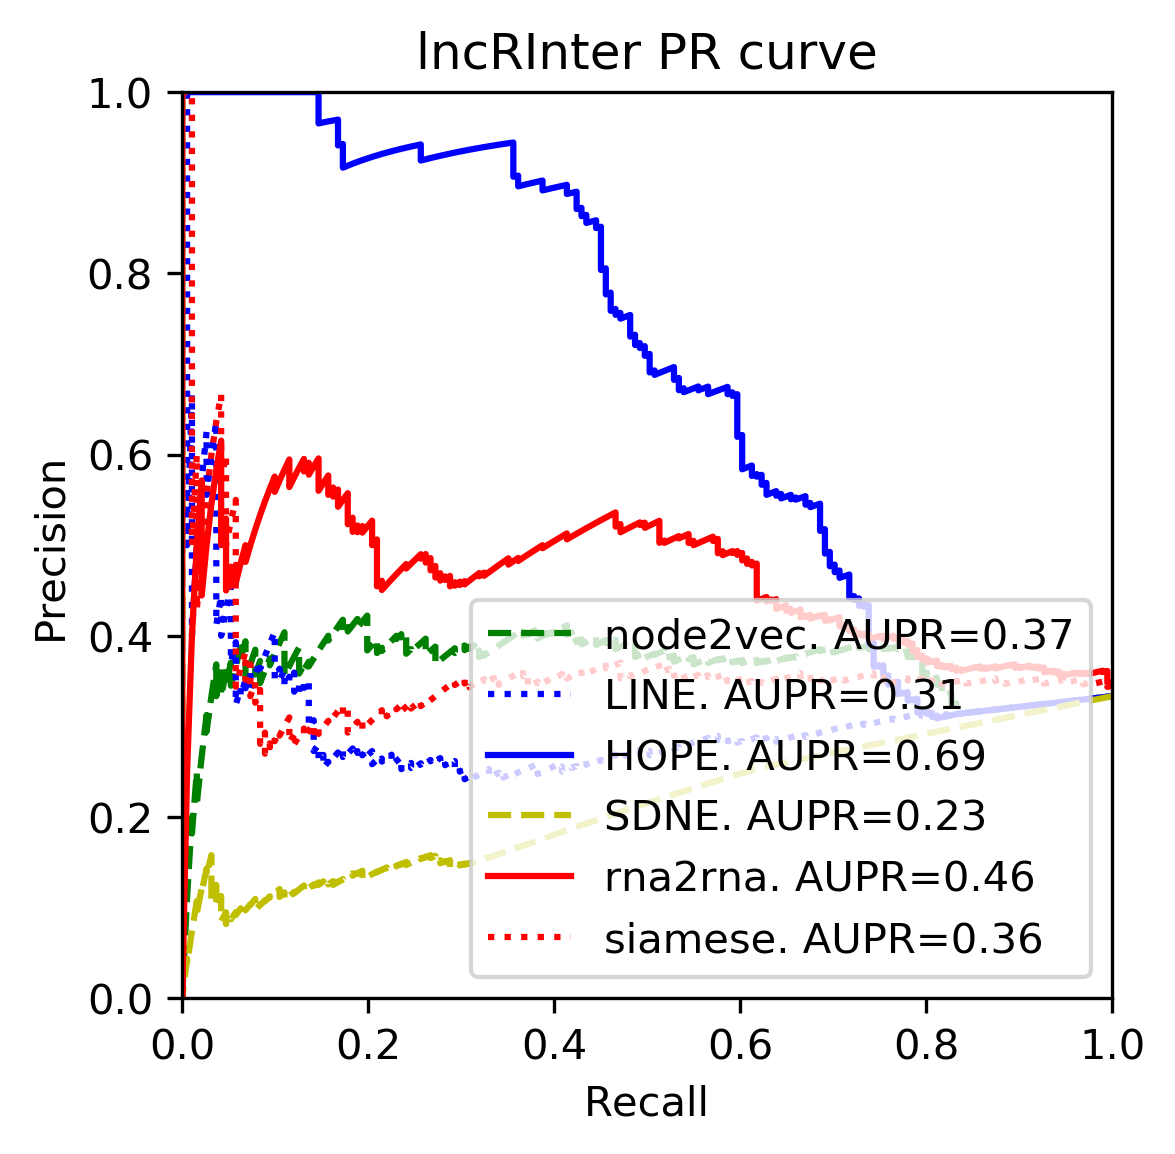

In [24]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_Ed, 
                                        databases=["lncrna2target", "miRTarBase", "BioGRID", "lncRInter"])

# Top-K Link Prediction

In [25]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=500))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE
{'precision': 0.0, 'recall': 0.0}
HOPE
{'precision': 0.0, 'recall': 0.0}
SDNE
{'precision': 0.0, 'recall': 0.0}
rna2rna
{'precision': 0.004, 'recall': 2.2553762531434306e-05}
siamese
{'precision': 0.0, 'recall': 0.0}


In [26]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.48498263667906605, 'completeness': 0.531774824665435, 'nmi': 0.507302019194935}
LINE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.49575321653929855, 'completeness': 0.5358625720043556, 'nmi': 0.5150281658042678}
HOPE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3921747704833031, 'completeness': 0.49652090830914425, 'nmi': 0.4382219423433855}
SDNE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3849890580270227, 'completeness': 0.4934218881583918, 'nmi': 0.43251288877248834}
rna2rna
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.48093398072092064, 'completeness': 0.5373728085116525, 'nmi': 0.5075893564913947}
siamese
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.4794547403643807, 'completeness': 0.5130897894642458, 'nmi': 0.49570235772428234}


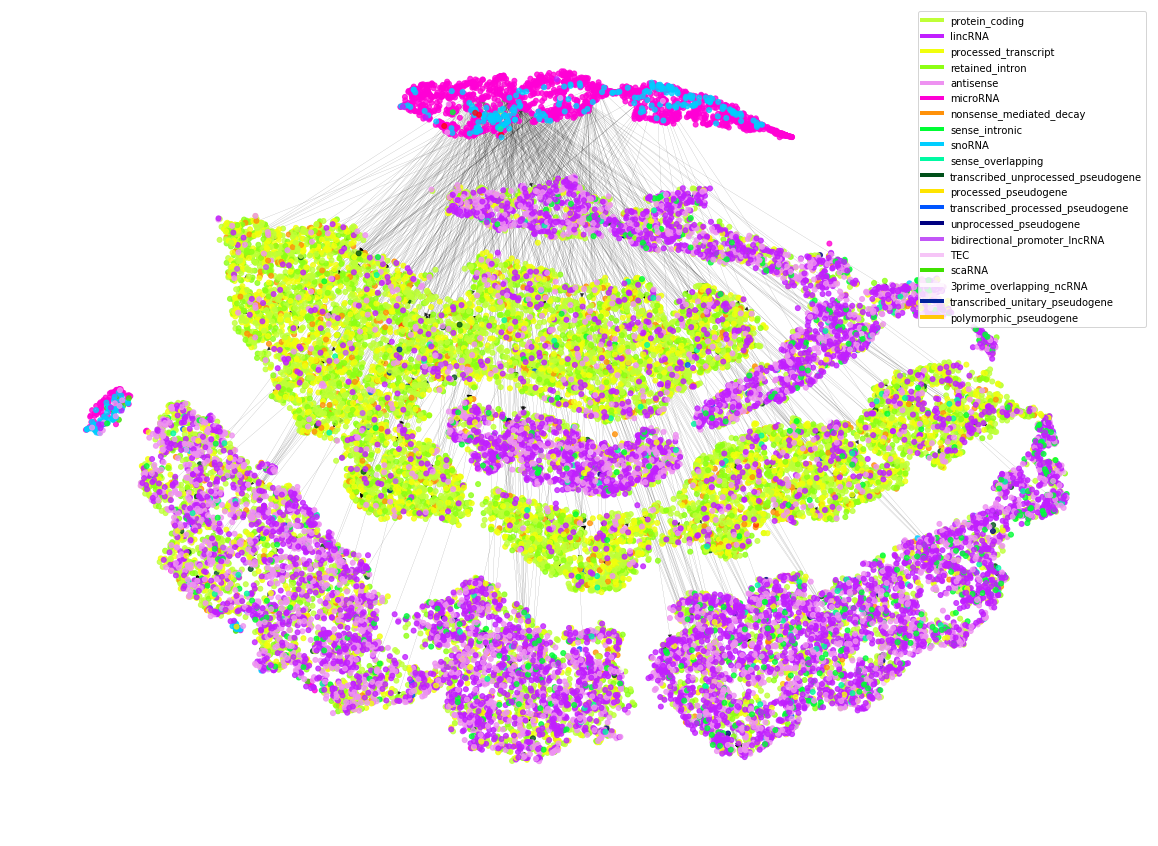

In [12]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network.node_list, edge_types=["d"])[:500],
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

In [ ]:
siamese.process_embeddings(variable_length=True)
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network.node_list, edge_types=["d"])[:500],
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

In [ ]:
delattr(siamese, "node_pos")

In [28]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Disease association", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])


node2vec
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.0171282291412354), ('score_time', 0.013227748870849609), ('test_precision_macro', 0.015807961860222746), ('test_recall_macro', 0.01783871074259305), ('test_f1_macro', 0.015503116146400295)]

LINE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.515778160095215), ('score_time', 0.026488542556762695), ('test_precision_macro', 0.025895864037130456), ('test_recall_macro', 0.02648393484470976), ('test_f1_macro', 0.025147635048809597)]

HOPE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 7.474565410614014), ('score_time', 0.009993219375610351), ('test_precision_macro', 0.02097219022375773), ('test_recall_macro', 0.029517858878904492), ('test_f1_macro', 0.02188662375622564)]

SDNE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 6.9618000984191895), ('score_time', 0.007739925384521484), ('test_precision_macro', 0.02066050648621585), ('test_recall_macro', 0.027921725058381936), ('test_f1_macro', 0.02109017211957741)]

rna2rna
# of labels with >cv samples: 105 , # of nodes to train/test: 1945
[('fit_time', 1.1708008766174316), ('score_time', 0.01809978485107422), ('test_precision_macro', 0.021497003538884712), ('test_recall_macro', 0.03327806696227749), ('test_f1_macro', 0.02234096124390922)]

siamese
# of labels with >cv samples: 105 , # of nodes to train/test: 1945
[('fit_time', 2.4876688003540037), ('score_time', 0.014688730239868164), ('test_precision_macro', 0.008417011592564413), ('test_recall_macro', 0.01673401452348821), ('test_f1_macro', 0.008188813250783532)]


In [27]:
for method in methods.keys():
    print("\n", method)
    print(methods[method].get_scalefree_fit_score(methods[method].node_list))
    # for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
    #    print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))


 node2vec


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


0.45677970159474224

 LINE
0.7580594588645865

 HOPE
0.7488113098677277

 SDNE


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))


0.1525965470069377

 rna2rna
0.24341163916415495

 siamese
0.7132998934087205


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


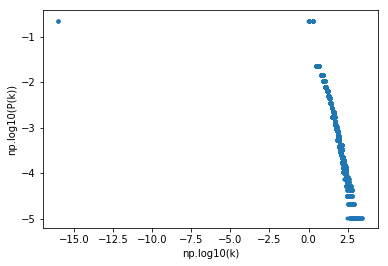

0.8423381196737936

In [25]:
from moge.evaluation.utils import get_scalefree_fit_score
adj = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)
network_degrees = np.sum(adj, axis=1)
get_scalefree_fit_score(network_degrees, plot=True)

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>